## DM2 RL Question 4

Deep Q Networks

In [ ]:
!pip install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip install torchvision

In [ ]:
!pip install gym -q

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from copy import deepcopy
import matplotlib.pyplot as plt
from typing_extensions import Literal

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class QNet(nn.Module):
    def __init__(self, obs_size, n_actions):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(obs_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, n_actions)

    def forward(self, state):
        # ====================================================
        # YOUR IMPLEMENTATION HERE
        ...

        # ====================================================
        return Q

    def select_greedyaction(self, state):
        with torch.no_grad():
            # ====================================================
            # YOUR IMPLEMENTATION HERE
            action_index = ...
            # ====================================================
        return action_index.item()


class Dueling_DQN(nn.Module):
    def __init__(self, obs_size, n_actions):
        super(Dueling_DQN, self).__init__()
        self.fc1 = nn.Linear(obs_size, 64)
        self.relu = nn.ReLU()
        self.V1_linear = nn.Linear(64, 256)
        self.V2_linear = nn.Linear(256, 1)
        self.A1_linear = nn.Linear(64, 256)
        self.A2_linear = nn.Linear(256, n_actions)

    def forward(self, state):
        Q = self.fc1(state)
        Q = self.relu(Q)

        # V branch
        Q_V = self.V1_linear(Q)
        Q_V = self.relu(Q_V)
        Q_V = self.V2_linear(Q_V)

        # A branch
        Q_A = self.A1_linear(Q)
        Q_A = self.relu(Q_A)
        Q_A = self.A2_linear(Q_A)

        # Q + A - mean A
        return Q_V + Q_A - Q_A.mean()

    def select_greedyaction(self, state):
        with torch.no_grad():
            # ====================================================
            # YOUR IMPLEMENTATION HERE

            action_index = ...
            # ====================================================
        return action_index.item()

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, sample):
        """Saves a transition.
        sample is a tuple (state, next_state, action, reward, done)
        """
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = sample
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch_size = min(len(self.memory), batch_size)
        samples = random.sample(self.memory, batch_size)
        return map(np.asarray, zip(*samples))

    def __len__(self):
        return len(self.memory)


def eval_dqn(env, q_net, n_sim=5):
    """
    Monte Carlo evaluation of DQN agent
    """
    rewards = np.zeros(n_sim)
    copy_env = deepcopy(env)  # Important!
    # Loop over number of simulations
    for sim in range(n_sim):
        state = copy_env.reset()
        done = False
        while not done:
            tensor_state = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = q_net.select_greedyaction(tensor_state)
            next_state, reward, done, _ = copy_env.step(action)
            # update sum of rewards
            rewards[sim] += reward
            state = next_state
    return rewards


# Discount factor
GAMMA = 0.99
EVAL_EVERY = 2

# Batch size
BATCH_SIZE = 256
# Capacity of the replay buffer
BUFFER_CAPACITY = 30000
# Update target net every ... episodes
UPDATE_TARGET_EVERY = 20

# Initial value of epsilon
EPSILON_START = 1.0
# Parameter to decrease epsilon
DECREASE_EPSILON = 200
# Minimum value of epislon
EPSILON_MIN = 0.05

# Number of training episodes
N_EPISODES = 250

LEARNING_RATE = 0.1
N_SCENARIOS = 10

def run_scenarios(ALGO: Literal["DQN", "DDQN", "Dueling DDQN"], N_SCENARIOS=N_SCENARIOS):

  result_scenarios = []
  for scenario in range(N_SCENARIOS):
    env = gym.make("CartPole-v0")

    # initialize replay buffer
    replay_buffer = ReplayBuffer(BUFFER_CAPACITY)

    # create network and target network
    obs_size = env.observation_space.shape[0]
    n_actions = env.action_space.n
    # ====================================================
    # YOUR IMPLEMENTATION HERE
    # Define networks


    # ====================================================

    # objective and optimizer
    optimizer = optim.Adam(params=q_net.parameters(), lr=LEARNING_RATE)

    # Algorithm
    state = env.reset()
    epsilon = EPSILON_START
    ep = 0
    total_time = 0
    learn_steps = 0
    episode_reward = 0

    episode_rewards = np.zeros((N_EPISODES, 3))
    while ep < N_EPISODES:
        # ====================================================
        # YOUR IMPLEMENTATION HERE
        # sample epsilon-greedy action


        # ====================================================

        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        total_time += 1

        # ====================================================
        # YOUR IMPLEMENTATION HERE
        # add sample to buffer


        # ====================================================

        if len(replay_buffer) > BATCH_SIZE:
            learn_steps += 1
            # UPDATE MODEL
            # get batch
            (
                batch_state,
                batch_next_state,
                batch_action,
                batch_reward,
                batch_done,
            ) = replay_buffer.sample(BATCH_SIZE)

            batch_state = torch.FloatTensor(batch_state).to(device)
            batch_next_state = torch.FloatTensor(batch_next_state).to(device)
            batch_action = torch.FloatTensor(batch_action).unsqueeze(1).to(device)
            batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
            batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

            with torch.no_grad():
                # ====================================================
                # YOUR IMPLEMENTATION HERE
                # build target (recall that we consider the Q function
                # in the next state only if not terminal, ie. done != 1)
                # (1- done) * value_next
                #
                # targets = ...

                # ====================================================

            values = q_net(batch_state).gather(1, batch_action.long())

            # ====================================================
            # YOUR IMPLEMENTATION HERE
            # compute loss and update model (loss and optimizer)
            loss = F.mse_loss(values, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # ====================================================

            if epsilon > EPSILON_MIN:
                epsilon -= (EPSILON_START - EPSILON_MIN) / DECREASE_EPSILON

        # ====================================================
        # YOUR IMPLEMENTATION HERE
        # update target network
        if learn_steps % UPDATE_TARGET_EVERY == 0:
            q_net_target.load_state_dict(q_net.state_dict())
        # ====================================================

        state = next_state
        if done:
            mean_rewards = -1
            if (ep + 1) % EVAL_EVERY == 0:
                # evaluate current policy
                rewards = eval_dqn(env, q_net)
                mean_rewards = np.mean(rewards)
                print(
                    "ALGO : ", ALGO,
                    "scenario : ",scenario,
                    "episode =",
                    ep,
                    ", reward = ",
                    np.round(np.mean(rewards), 2),
                    ", obs_rew = ",
                    episode_reward
                )
                # if np.mean(rewards) >= REWARD_THRESHOLD:
                #     break

            episode_rewards[ep] = [total_time, episode_reward, mean_rewards]
            state = env.reset()
            ep += 1
            episode_reward = 0
    result_scenarios.append(episode_rewards)

    ###################################################################
    # VISUALIZATION
    ###################################################################
    if False:
      for episode in range(3):
          done = False
          state = env.reset()
          env.render()
          while not done:
              tensor_state = torch.FloatTensor(state).unsqueeze(0).to(device)
              action = q_net.select_greedyaction(tensor_state)
              state, reward, done, info = env.step(action)
              env.render()


    plt.figure()
    plt.title(f"Performance over learning for scenario {scenario}")
    plt.plot(episode_rewards[:, 0], episode_rewards[:, 1])
    plt.xlabel("time steps")
    plt.ylabel("total reward")

    plt.figure()
    plt.title(f"Performance on Test Env for scenario {scenario}")
    xv = np.arange(EVAL_EVERY - 1, N_EPISODES + 1, EVAL_EVERY)
    plt.plot(episode_rewards[xv, 0], episode_rewards[xv, 2], ":o")
    plt.xlabel("time steps")
    plt.ylabel("expected total reward (greedy policy)")
    plt.show()

  return result_scenarios


result_scenarios_1  = run_scenarios(ALGO="DQN")
result_scenarios_2  = run_scenarios(ALGO="DDQN")
result_scenarios_3  = run_scenarios(ALGO="Dueling DDQN")


In [ ]:
def plot_result_scenarios(result_scenarios, ALGO):
  # calculate the mean and std
  mean_reward = np.zeros((N_EPISODES, 3))
  mean_reward[:, 0] = result_scenarios[0][:, 0]
  std_reward = np.zeros((N_EPISODES, 3))
  std_reward[:, 0] = result_scenarios[0][:, 0]
  upper_reward = np.zeros((N_EPISODES, 3))
  upper_reward[:, 0] = result_scenarios[0][:, 0]
  lower_reward = np.zeros((N_EPISODES, 3))
  lower_reward[:, 0] = result_scenarios[0][:, 0]

  for episode in range(N_EPISODES):
    for j in [1, 2]:
      res = []
      for scenario in range(len(result_scenarios)):
        res.append(result_scenarios[scenario][episode, j])
      res = np.array(res)
      mean_reward[episode, j] = res.mean()
      std_reward[episode, j] = res.std()
      upper_reward[episode, j] = res.mean() + (1.96 * res.std()/np.sqrt(len(result_scenarios)))
      lower_reward[episode, j] = res.mean() - (1.96 * res.std()/np.sqrt(len(result_scenarios)))

  plt.figure(1)
  plt.title("Mean performance over learning")
  plt.plot(mean_reward[:, 0], mean_reward[:, 1], label=ALGO)
  plt.fill_between(mean_reward[:, 0], lower_reward[:, 1], upper_reward[:, 1], alpha=0.2)
  plt.xlabel("time steps")
  plt.ylabel("total reward")
  plt.legend()

  plt.figure(2)
  plt.title("Mean performance on Test Env")
  xv = np.arange(EVAL_EVERY - 1, N_EPISODES + 1, EVAL_EVERY)
  plt.plot(mean_reward[xv, 0], mean_reward[xv, 2], ":o", label=ALGO)
  plt.fill_between(mean_reward[xv, 0], lower_reward[xv, 2], upper_reward[xv, 2], alpha=0.2)
  plt.xlabel("time steps")
  plt.ylabel("expected total reward (greedy policy)")
  plt.legend()

### Learning Rate = 0.001

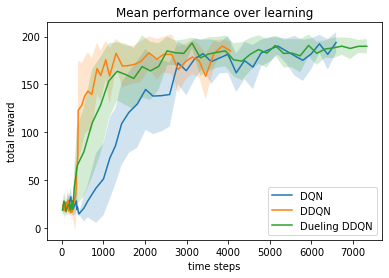

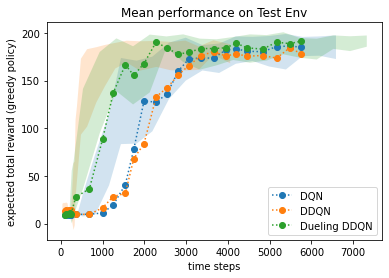

In [ ]:
# plot here the results for a learning rate of 0.001

plot_result_scenarios(result_scenarios_1, ALGO="DQN")

# Bonus
# plot_result_scenarios(result_scenarios_2, ALGO="DDQN")
# plot_result_scenarios(result_scenarios_3, ALGO="Dueling DDQN")
plt.show()

We can see in the figure above that for a learning rate of 0.001, NDD dueling converges faster than NDD and Double NDD, which are both equivalent to each other.

### Learning Rate = 0.1

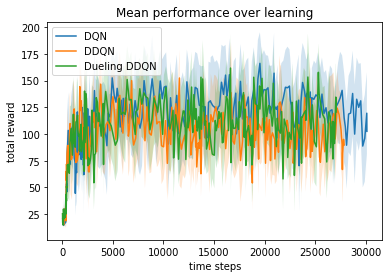

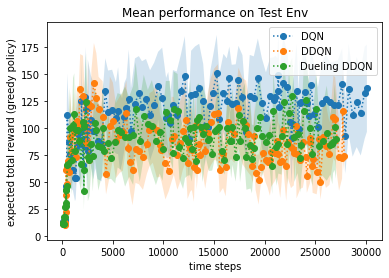

In [ ]:
plot_result_scenarios(result_scenarios_1, ALGO="DQN")

# Bonus
# plot_result_scenarios(result_scenarios_2, ALGO="DDQN")
# plot_result_scenarios(result_scenarios_3, ALGO="Dueling DDQN")
plt.show()

The learning rate initially given of 0.1 is far too unstable. Even after many 250 episodes, there is very little convergence, and you can see in the figure that the variance is very high.